##Human + GenAI Contact-Centre Planning — Working Demo (LP with HiGHS)

/tmp/ipython-input-1380819698.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: sla_floor_ratio * (g["aH_min_per_contact"] * g["demand"]).sum())


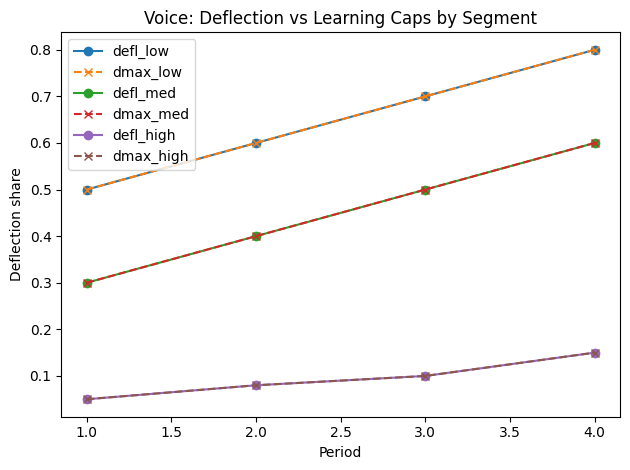

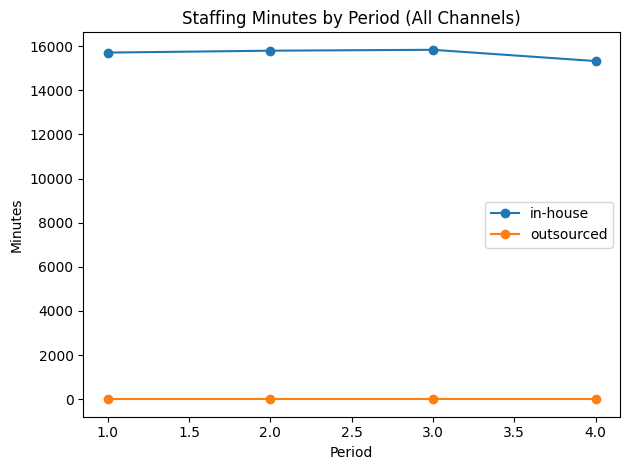


--- Summary ---
 total_cost  cost_inhouse_outsource  ai_minutes  ai_cost  csat_penalty_cost  sla_shortfall_minutes
   31294.66                30045.66    15362.49   1229.0               20.0                7949.54

Files saved in: /content/outputs


In [4]:
"""
What this script does:
1) Creates a synthetic multi-channel, multi-segment, multi-period dataset
2) Builds a linear program:
   - vars: in-house minutes (x), outsourced minutes (y),
           AI deflection shares (d), human-handled contacts (u), SLA slack (s)
   - objective: staffing cost + AI cost + SLA shortfall penalty + CSAT penalty
   - constraints: demand balance, capacity linking, SLA floors, deflection caps
3) Solves with scipy.optimize.linprog (HiGHS)
4) Returns results as DataFrames and saves CSVs

This is a didactic demo for your report — not production code.
"""

from __future__ import annotations
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- Optional plotting ----------
try:
    import matplotlib.pyplot as plt
    HAS_PLOT = True
except Exception:
    HAS_PLOT = False

# ---------- Solver ----------
try:
    from scipy.optimize import linprog
    HAS_SCIPY = True
except Exception as e:
    HAS_SCIPY = False
    SCIPY_ERR = str(e)


def generate_synthetic_params(
    seed: int = 42,
    channels: list[str] = ("voice", "email", "chat"),
    segments: list[str] = ("low", "med", "high"),
    periods: list[int] = (1, 2, 3, 4),
) -> tuple[pd.DataFrame, pd.DataFrame, dict, dict, float, dict, float]:
    """
    Create synthetic parameters for the LP.
    Returns:
        params: panel with demand, minutes per contact, costs, dmax
        sla_floor: κ_ct for each (channel, period)
        wH, wOUT: per-minute costs dicts for in-house and outsourcing
        wAI_per_min: AI minute cost (float)
        csat_penalty: per-deflected-contact penalty by segment
        penalty_SLA: per-minute penalty for SLA shortfall
    """
    np.random.seed(seed)

    # Base demand per channel per period
    base_dem = {"voice": 1200, "email": 900, "chat": 1400}

    # Segment mix (sum to 1 per channel)
    seg_mix = pd.DataFrame(
        {
            "segment": segments,
            "voice": [0.55, 0.30, 0.15],
            "email": [0.45, 0.40, 0.15],
            "chat":  [0.60, 0.30, 0.10],
        }
    ).set_index("segment")

    # Time growth multipliers
    t_growth = {1: 1.00, 2: 1.05, 3: 1.10, 4: 1.12}

    # Handling minutes per contact (human)
    aH_seg = {"low": 4.0, "med": 7.0, "high": 12.0}

    # Channel multipliers (voice longer, chat shorter)
    chan_mult = {"voice": 1.15, "email": 0.95, "chat": 0.85}

    # AI is efficient: fraction of human minutes
    ai_eff_frac = 0.6

    # Costs per staffed minute
    wH = {"voice": 0.65, "email": 0.45, "chat": 0.35}
    wOUT = {c: 1.35 * wH[c] for c in channels}
    wAI_per_min = 0.08

    # SLA floor proxy (κ_ct): 80% of no-AI busy minutes
    sla_floor_ratio = 0.80

    # Penalties
    penalty_SLA = 0.50  # per minute short
    csat_penalty = {"low": 0.0, "med": 0.02, "high": 0.06}  # per deflected contact

    # Learning/quality rollout caps (d_max) by segment & period
    dmax_time = {
        "low":  {1: 0.50, 2: 0.60, 3: 0.70, 4: 0.80},
        "med":  {1: 0.30, 2: 0.40, 3: 0.50, 4: 0.60},
        "high": {1: 0.05, 2: 0.08, 3: 0.10, 4: 0.15},
    }

    rows = []
    for c in channels:
        for s in segments:
            for t in periods:
                D = int(round(base_dem[c] * t_growth[t] * seg_mix.loc[s, c]))
                aH = aH_seg[s] * chan_mult[c]
                aAI = aH * ai_eff_frac
                rows.append(
                    {
                        "channel": c,
                        "segment": s,
                        "period": t,
                        "demand": D,
                        "aH_min_per_contact": aH,
                        "aAI_min_per_contact": aAI,
                        "wH_per_min": wH[c],
                        "wOUT_per_min": wOUT[c],
                        "wAI_per_min": wAI_per_min,
                        "dmax": dmax_time[s][t],
                    }
                )
    params = pd.DataFrame(rows)

    # SLA floor per (channel, period): κ_ct = ratio * sum_s aH * demand
    sla = (
        params.groupby(["channel", "period"])
        .apply(lambda g: sla_floor_ratio * (g["aH_min_per_contact"] * g["demand"]).sum())
        .reset_index(name="kappa_floor")
    )

    return params, sla, wH, wOUT, wAI_per_min, csat_penalty, penalty_SLA


def build_lp(
    params: pd.DataFrame,
    sla: pd.DataFrame,
    wH: dict,
    wOUT: dict,
    wAI_per_min: float,
    csat_penalty: dict,
    penalty_SLA: float,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[tuple[float | None, float | None]], dict]:
    """
    Build LP matrices for:
        min c^T x
        A_ub x <= b_ub
        bounds
    Returns (c, A_ub, b_ub, bounds, index_maps)
    """
    channels = list(params["channel"].unique())
    segments = list(params["segment"].unique())
    periods = list(params["period"].unique())

    P = params.set_index(["channel", "segment", "period"])
    SLA = sla.set_index(["channel", "period"])

    # Indices for variables
    idx_d, idx_u, idx_x, idx_y, idx_s = {}, {}, {}, {}, {}
    cols, col_ix = [], 0

    # Order: d (c,s,t), u (c,s,t), then x,y,s (c,t)
    for c in channels:
        for s in segments:
            for t in periods:
                idx_d[(c, s, t)] = col_ix
                cols.append(("d", c, s, t))
                col_ix += 1
    for c in channels:
        for s in segments:
            for t in periods:
                idx_u[(c, s, t)] = col_ix
                cols.append(("u", c, s, t))
                col_ix += 1
    for c in channels:
        for t in periods:
            idx_x[(c, t)] = col_ix; cols.append(("x", c, None, t)); col_ix += 1
            idx_y[(c, t)] = col_ix; cols.append(("y", c, None, t)); col_ix += 1
            idx_s[(c, t)] = col_ix; cols.append(("s", c, None, t)); col_ix += 1

    nvar = col_ix
    c_obj = np.zeros(nvar)

    # Objective coefficients
    for c in channels:
        for s in segments:
            for t in periods:
                D = P.loc[(c, s, t), "demand"]
                aAI = P.loc[(c, s, t), "aAI_min_per_contact"]
                c_obj[idx_d[(c, s, t)]] += D * aAI * wAI_per_min     # AI minute cost
                c_obj[idx_d[(c, s, t)]] += D * csat_penalty[s]       # CSAT penalty (linear proxy)
                # u has zero direct cost
    for c in channels:
        for t in periods:
            c_obj[idx_x[(c, t)]] += wH[c]
            c_obj[idx_y[(c, t)]] += wOUT[c]
            c_obj[idx_s[(c, t)]] += penalty_SLA

    # Constraints A_ub x <= b_ub
    A_ub = []
    b_ub = []

    # 1) Flow balance: u + d*D >= D  ->  -u - d*D <= -D
    for c in channels:
        for s in segments:
            for t in periods:
                row = np.zeros(nvar)
                D = P.loc[(c, s, t), "demand"]
                row[idx_u[(c, s, t)]] = -1.0
                row[idx_d[(c, s, t)]] = -D
                A_ub.append(row)
                b_ub.append(-D)

    # 2) Capacity link: sum_s aH * u <= x + y  -> sum_s aH u - x - y <= 0
    for c in channels:
        for t in periods:
            row = np.zeros(nvar)
            for s in segments:
                aH = P.loc[(c, s, t), "aH_min_per_contact"]
                row[idx_u[(c, s, t)]] = aH
            row[idx_x[(c, t)]] = -1.0
            row[idx_y[(c, t)]] = -1.0
            A_ub.append(row)
            b_ub.append(0.0)

    # 3) SLA floor: x + y + s >= kappa  ->  -x - y - s <= -kappa
    for c in channels:
        for t in periods:
            row = np.zeros(nvar)
            kappa = SLA.loc[(c, t), "kappa_floor"]
            row[idx_x[(c, t)]] = -1.0
            row[idx_y[(c, t)]] = -1.0
            row[idx_s[(c, t)]] = -1.0
            A_ub.append(row)
            b_ub.append(-kappa)

    A_ub = np.vstack(A_ub)
    b_ub = np.array(b_ub)

    # Bounds
    bounds: list[tuple[float | None, float | None]] = [None] * nvar

    # d in [0, dmax]
    for c in channels:
        for s in segments:
            for t in periods:
                dmax = float(P.loc[(c, s, t), "dmax"])
                bounds[idx_d[(c, s, t)]] = (0.0, dmax)

    # u, x, y, s >= 0
    for c in channels:
        for s in segments:
            for t in periods:
                bounds[idx_u[(c, s, t)]] = (0.0, None)
    for c in channels:
        for t in periods:
            bounds[idx_x[(c, t)]] = (0.0, None)
            bounds[idx_y[(c, t)]] = (0.0, None)
            bounds[idx_s[(c, t)]] = (0.0, None)

    index_maps = {"idx_d": idx_d, "idx_u": idx_u, "idx_x": idx_x, "idx_y": idx_y, "idx_s": idx_s}
    return c_obj, A_ub, b_ub, bounds, index_maps


def solve_lp(c: np.ndarray, A_ub: np.ndarray, b_ub: np.ndarray, bounds) -> np.ndarray:
    """Solve LP with HiGHS. Returns solution x (1-D array)."""
    if not HAS_SCIPY:
        raise RuntimeError(f"SciPy not available. Install scipy. Error: {SCIPY_ERR}")
    res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP did not converge: {res.message}")
    return res.x


def extract_solution(
    x: np.ndarray,
    index_maps: dict,
    params: pd.DataFrame,
    sla: pd.DataFrame,
    wH: dict,
    wOUT: dict,
    wAI_per_min: float,
    csat_penalty: dict,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Build tidy solution tables and a one-row cost summary.
    Returns: df_deflection, df_staffing, df_humcontacts, df_summary
    """
    channels = list(params["channel"].unique())
    segments = list(params["segment"].unique())
    periods = list(params["period"].unique())

    P = params.set_index(["channel", "segment", "period"])
    SLA = sla.set_index(["channel", "period"])

    idx_d, idx_u, idx_x, idx_y, idx_s = (
        index_maps["idx_d"],
        index_maps["idx_u"],
        index_maps["idx_x"],
        index_maps["idx_y"],
        index_maps["idx_s"],
    )

    recs_d, recs_u, recs_xy = [], [], []

    for c in channels:
        for s in segments:
            for t in periods:
                recs_d.append(
                    {
                        "channel": c,
                        "segment": s,
                        "period": t,
                        "deflection_share": x[idx_d[(c, s, t)]],
                        "dmax": float(P.loc[(c, s, t), "dmax"]),
                    }
                )
                recs_u.append(
                    {
                        "channel": c,
                        "segment": s,
                        "period": t,
                        "human_contacts": x[idx_u[(c, s, t)]],
                    }
                )

    for c in channels:
        for t in periods:
            recs_xy.append(
                {
                    "channel": c,
                    "period": t,
                    "x_inhouse_minutes": x[idx_x[(c, t)]],
                    "y_outsourced_minutes": x[idx_y[(c, t)]],
                    "s_sla_shortfall_minutes": x[idx_s[(c, t)]],
                    "kappa_floor": float(SLA.loc[(c, t), "kappa_floor"]),
                }
            )

    df_d = pd.DataFrame(recs_d)
    df_u = pd.DataFrame(recs_u)
    df_xy = pd.DataFrame(recs_xy)

    # Cost components
    cost_xy = 0.0
    for c in channels:
        for t in periods:
            cost_xy += wH[c] * x[idx_x[(c, t)]] + wOUT[c] * x[idx_y[(c, t)]]

    ai_minutes = 0.0
    ai_cost = 0.0
    csat_cost = 0.0
    for c in channels:
        for s in segments:
            for t in periods:
                D = P.loc[(c, s, t), "demand"]
                aAI = P.loc[(c, s, t), "aAI_min_per_contact"]
                dval = x[idx_d[(c, s, t)]]
                ai_minutes += D * dval * aAI
                ai_cost += D * dval * aAI * wAI_per_min
                csat_cost += D * dval * csat_penalty[s]

    sla_shortfall = df_xy["s_sla_shortfall_minutes"].sum()
    # penalty_SLA already folded into objective via variable 's'; not recomputed here

    total_cost = cost_xy + ai_cost + csat_cost + 0.0  # (SLA penalty was in s-variable objective)

    df_summary = pd.DataFrame(
        [
            {
                "total_cost": total_cost,
                "cost_inhouse_outsource": cost_xy,
                "ai_minutes": ai_minutes,
                "ai_cost": ai_cost,
                "csat_penalty_cost": csat_cost,
                "sla_shortfall_minutes": sla_shortfall,
            }
        ]
    )
    return df_d, df_xy, df_u, df_summary


def save_outputs(
    outdir: str | Path,
    params: pd.DataFrame,
    sla: pd.DataFrame,
    df_d: pd.DataFrame,
    df_xy: pd.DataFrame,
    df_u: pd.DataFrame,
    df_summary: pd.DataFrame,
) -> None:
    """Save CSV outputs for your appendix."""
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    params.to_csv(outdir / "synthetic_params.csv", index=False)
    sla.to_csv(outdir / "synthetic_sla_floor.csv", index=False)
    df_d.to_csv(outdir / "solution_deflection.csv", index=False)
    df_u.to_csv(outdir / "solution_human_contacts.csv", index=False)
    df_xy.to_csv(outdir / "solution_staffing.csv", index=False)
    df_summary.to_csv(outdir / "solution_summary.csv", index=False)


def quick_plots(df_d: pd.DataFrame, df_xy: pd.DataFrame) -> None:
    """Two quick visuals (skips if matplotlib not installed)."""
    if not HAS_PLOT:
        print("matplotlib not installed — skipping charts.")
        return

    segments = ["low", "med", "high"]

    # 1) Deflection vs caps for 'voice'
    sub = df_d[df_d["channel"] == "voice"].pivot(index="period", columns="segment", values="deflection_share")
    sub_max = df_d[df_d["channel"] == "voice"].pivot(index="period", columns="segment", values="dmax")
    plt.figure()
    for s in segments:
        plt.plot(sub.index, sub[s], marker="o", label=f"defl_{s}")
        plt.plot(sub_max.index, sub_max[s], linestyle="--", marker="x", label=f"dmax_{s}")
    plt.title("Voice: Deflection vs Learning Caps by Segment")
    plt.xlabel("Period")
    plt.ylabel("Deflection share")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Staffing minutes (sum over channels)
    staff = df_xy.groupby("period")[["x_inhouse_minutes", "y_outsourced_minutes"]].sum()
    plt.figure()
    plt.plot(staff.index, staff["x_inhouse_minutes"], marker="o", label="in-house")
    plt.plot(staff.index, staff["y_outsourced_minutes"], marker="o", label="outsourced")
    plt.title("Staffing Minutes by Period (All Channels)")
    plt.xlabel("Period")
    plt.ylabel("Minutes")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main(save_dir: str | Path = "./outputs") -> None:
    # 1) Data
    params, sla, wH, wOUT, wAI_per_min, csat_penalty, penalty_SLA = generate_synthetic_params()

    # 2) LP
    c, A_ub, b_ub, bounds, index_maps = build_lp(
        params=params,
        sla=sla,
        wH=wH,
        wOUT=wOUT,
        wAI_per_min=wAI_per_min,
        csat_penalty=csat_penalty,
        penalty_SLA=penalty_SLA,
    )

    # 3) Solve
    x = solve_lp(c, A_ub, b_ub, bounds)

    # 4) Extract tidy outputs
    df_d, df_xy, df_u, df_summary = extract_solution(
        x=x,
        index_maps=index_maps,
        params=params,
        sla=sla,
        wH=wH,
        wOUT=wOUT,
        wAI_per_min=wAI_per_min,
        csat_penalty=csat_penalty,
    )

    # 5) Save for appendix
    save_outputs(save_dir, params, sla, df_d, df_xy, df_u, df_summary)

    # 6) Quick visuals (optional)
    quick_plots(df_d, df_xy)

    # Console summary
    print("\n--- Summary ---")
    print(df_summary.round(2).to_string(index=False))
    print(f"\nFiles saved in: {Path(save_dir).resolve()}")


if __name__ == "__main__":
    main()
